In [ ]:
import requests#產生HTTP請求的函式庫
import datetime#處理日期和時間的函式庫
import pandas as pd#資料處理和分析的函式庫
import matplotlib.pyplot as plt#繪圖函式庫

import numpy as np#處理矩陣、陣列運算的函式庫
#import gc#請理電腦及編譯迄無用資源的函式庫

#安裝keras機器學習庫
!pip install -q keras
import keras
from keras.models import Sequential#匯入 Sequential() 以便進行建造身經網路架構
from keras.layers import Activation, Dense#引入激勵函數以及層數
from keras.layers import LSTM#引入LSTM演算法
from keras.layers import Dropout#引入dropout 正規化

import tensorflow as tf

#魔法函數，這樣就不需要在繪圖設定後加上plt.show()這句話就可以直接繪圖了
%matplotlib inline

You should consider upgrading via the 'c:\users\劉振豐\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [ ]:
window_len = 7

In [ ]:
def get_market_data(symbol, comparison_symbol, limit,aggregate, tag=True, exchange='', all_data=True):#從cryptocompare中找歷史資料
    url = 'https://min-api.cryptocompare.com/data/histoday?fsym={}&tsym={}&limit={}&aggregate={}'\
            .format(symbol.upper(), comparison_symbol.upper(), limit, aggregate)
    print(url)
    if exchange:
        url += '&e={}'.format(exchange)
    print(url)
    page = requests.get(url)
    data = page.json()['Data']#取json上的Data字典
    df = pd.DataFrame(data)#將字典轉換成pandas的陣列
    df['timestamp'] = [datetime.datetime.fromtimestamp(d) for d in df.time]#增加timestamp行，為每個time所對應到的當地時間
    if tag:
        df.columns = [df.columns[0]] + [tag + "_" + i for i in  df.columns[1:7]] +  [df.columns[i] for i in range(7,10)]#將資料前面加上幣種
    return df
def show_plot(data, tag):#將歷史價格資料(USD)繪製成折線圖、成交量(USD)繪製成長條圖
  fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})#將畫面分成高度為3:1的樣子
  ax1.set_ylabel('Closing Price ($)',fontsize=12)#設置Y軸標題
  ax2.set_ylabel('Volume ($ USD)',fontsize=12)
  ax1.plot(data.timestamp, data[tag+"_close"])#繪製第一張圖
  plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)#將X軸文字傾斜45度
  ax2.bar(data.timestamp, data[tag+"_volumeto"])#繪製第二張圖
  plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)#將X、Y軸文字都傾斜45度
  plt.setp(ax2.yaxis.get_majorticklabels(), rotation=45)
  fig.tight_layout()#自動調整介面
  plt.show()#顯示
def merge_data(a, b):#合併a,b陣列
    merged_data = pd.merge(a, b, on=['timestamp'])
    #merged_data = merged_data[merged_data['timestamp'] >= from_date]
    return merged_data
def create_model_data(data):#製造資料庫
  """
  data: pandas DataFrame
  This function drops unnecessary columns and reverses the order of DataFrame based on decending dates.
  Return: pandas DataFrame
  """
  #$data = data[['timestamp']+[coin+metric for coin in ['btc_', 'eth_'] for metric in ['Close','Volume','close_off_high','volatility']]]
  data = data[['timestamp']+[coin+metric for coin in ['BTC_', 'ETH_'] for metric in ['close','volumeto']]]#只取closse、timestamp和volumeto這三行資料
  data = data.sort_values(by='timestamp')#以日期為排列順序，由早到晚
  return data

def split_data(data, training_size=0.8):#分割資料集為前0.8:0.2
  """
  data: Pandas Dataframe
  training_size: proportion of the data to be used for training
  This function splits the data into training_set and test_set based on the given training_size
  Return: train_set and test_set as pandas DataFrame
  """
  return data[:int(training_size*len(data))], data[int(training_size*len(data)):]
def create_inputs(data, coins=['BTC', 'ETH'], window_len=window_len):#製造input資料型態，將close以及volumeto正規化介於0~1
  """
  data: pandas DataFrame, this could be either training_set or test_set
  coins: coin datas which will be used as the input. Default is 'btc', 'eth'
  window_len: is an intiger to be used as the look back window for creating a single input sample.
  This function will create input array X from the given dataset and will normalize 'Close' and 'Volume' between 0 and 1
  Return: X, the input for our model as a python list which later needs to be converted to numpy array.
  """
  norm_cols = [coin + metric for coin in coins for metric in ['_close', '_volumeto']]#取輸入陣列中的close、volumeto 列
  inputs = []#初始化input陣列
  for i in range(len(data) - window_len+1):#從0到data的倒數第八個，跑n-7次
    temp_set = data[i:(i + window_len)].copy()#淺複製(shallow copy)資料到temp_set，一次會複製七個數
    inputs.append(temp_set)
    for col in norm_cols:
      inputs[i].loc[:, col] = inputs[i].loc[:, col] / inputs[i].loc[:, col].iloc[0] - 1
  return inputs
def to_array(data):#將輸入轉換為numpy陣列
  """
  data: DataFrame
  This function will convert list of inputs to a numpy array
  Return: numpy array
  """
  x = [np.array(data[i]) for i in range (len(data))]
  return np.array(x)
def add_volatility(data, coins=['BTC', 'ETH']):#增加一行新的資料:波動性
  """
  data: input data, pandas DataFrame
  coins: default is for 'btc and 'eth'. It could be changed as needed
  This function calculates the volatility and close_off_high of each given coin in 24 hours,
  and adds the result as new columns to the DataFrame.
  Return: DataFrame with added columns
  """
  for coin in coins:
    # calculate the daily change
    kwargs = {coin + '_change': lambda x: (x[coin + '_close'] - x[coin + '_open']) / x[coin + '_open'],#今天漲跌幅度
             coin + '_close_high': lambda x: 2*(x[coin + '_high'] - x[coin + '_close']) / (x[coin + '_high'] - x[coin + '_low']) - 1,#比較收盤價較靠近最低價還是最高價，負數代表較靠近最高價，正數則代表較靠近最低價
             coin + '_volatility': lambda x: (x[coin + '_high'] - x[coin + '_low']) / (x[coin + '_open'])}#顯示出今天市場波動大小
    data = data.assign(**kwargs)#新增新的行
  return data

In [ ]:
btc_data = get_market_data("BTC", "USD", 6, 1, "BTC")
eth_data = get_market_data("ETH", "USD", 6, 1, "ETH")

https://min-api.cryptocompare.com/data/histoday?fsym=BTC&tsym=USD&limit=6&aggregate=1
https://min-api.cryptocompare.com/data/histoday?fsym=BTC&tsym=USD&limit=6&aggregate=1
https://min-api.cryptocompare.com/data/histoday?fsym=ETH&tsym=USD&limit=6&aggregate=1
https://min-api.cryptocompare.com/data/histoday?fsym=ETH&tsym=USD&limit=6&aggregate=1


In [ ]:
btc_data.head(7)

,time,BTC_high,BTC_low,BTC_open,BTC_volumefrom,BTC_volumeto,BTC_close,conversionType,conversionSymbol,timestamp
0,1625443200,35290.80,33151.51,35287.97,31526.39,1.072690e+09,33702.79,direct,,2021-07-05 08:00:00
1,1625529600,35096.65,33558.75,33702.79,32844.80,1.123145e+09,34237.66,direct,,2021-07-06 08:00:00
2,1625616000,35066.82,33807.42,34237.66,21784.20,7.520745e+08,33880.79,direct,,2021-07-07 08:00:00
3,1625702400,33934.31,32108.68,33880.79,47884.76,1.573968e+09,32874.01,direct,,2021-07-08 08:00:00
4,1625788800,34076.49,32274.31,32874.01,25677.95,8.531654e+08,33804.20,direct,,2021-07-09 08:00:00
5,1625875200,34253.50,33030.16,33804.20,19345.51,6.518995e+08,33515.13,direct,,2021-07-10 08:00:00
6,1625961600,33868.25,33335.40,33515.13,6897.41,2.320161e+08,33801.67,direct,,2021-07-11 08:00:00


In [ ]:
eth_data.head(8)

,time,ETH_high,ETH_low,ETH_open,ETH_volumefrom,ETH_volumeto,ETH_close,conversionType,conversionSymbol,timestamp
0,1625443200,2323.53,2159.57,2323.27,364621.13,8.170322e+08,2196.71,direct,,2021-07-05 08:00:00
1,1625529600,2349.66,2194.97,2196.71,371318.48,8.526733e+08,2322.63,direct,,2021-07-06 08:00:00
2,1625616000,2408.53,2294.71,2322.63,327127.26,7.711741e+08,2317.12,direct,,2021-07-07 08:00:00
3,1625702400,2324.72,2084.63,2317.12,766987.58,1.669544e+09,2114.51,direct,,2021-07-08 08:00:00
4,1625788800,2186.26,2048.12,2114.51,594562.44,1.261710e+09,2145.67,direct,,2021-07-09 08:00:00
5,1625875200,2190.77,2075.55,2145.67,254162.69,5.392041e+08,2110.47,direct,,2021-07-10 08:00:00
6,1625961600,2137.72,2081.93,2110.47,81860.49,1.725594e+08,2126.89,direct,,2021-07-11 08:00:00


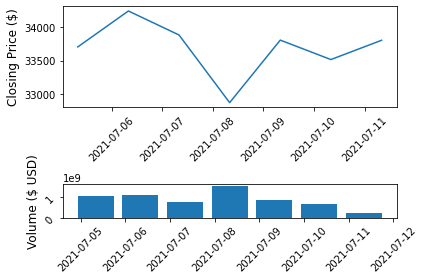

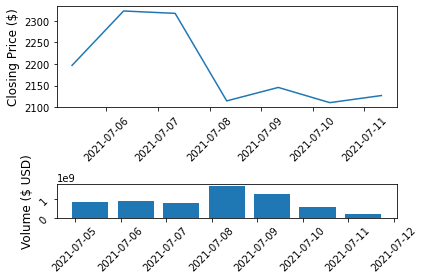

In [ ]:
show_plot(btc_data,"BTC")
show_plot(eth_data,"ETH")

In [ ]:
market_data = merge_data(btc_data, eth_data)
input_data = create_model_data(market_data)

In [ ]:
market_data

,time_x,BTC_high,BTC_low,BTC_open,BTC_volumefrom,BTC_volumeto,BTC_close,conversionType_x,conversionSymbol_x,timestamp,time_y,ETH_high,ETH_low,ETH_open,ETH_volumefrom,ETH_volumeto,ETH_close,conversionType_y,conversionSymbol_y
0,1625443200,35290.80,33151.51,35287.97,31526.39,1.072690e+09,33702.79,direct,,2021-07-05 08:00:00,1625443200,2323.53,2159.57,2323.27,364621.13,8.170322e+08,2196.71,direct,
1,1625529600,35096.65,33558.75,33702.79,32844.80,1.123145e+09,34237.66,direct,,2021-07-06 08:00:00,1625529600,2349.66,2194.97,2196.71,371318.48,8.526733e+08,2322.63,direct,
2,1625616000,35066.82,33807.42,34237.66,21784.20,7.520745e+08,33880.79,direct,,2021-07-07 08:00:00,1625616000,2408.53,2294.71,2322.63,327127.26,7.711741e+08,2317.12,direct,
3,1625702400,33934.31,32108.68,33880.79,47884.76,1.573968e+09,32874.01,direct,,2021-07-08 08:00:00,1625702400,2324.72,2084.63,2317.12,766987.58,1.669544e+09,2114.51,direct,
4,1625788800,34076.49,32274.31,32874.01,25677.95,8.531654e+08,33804.20,direct,,2021-07-09 08:00:00,1625788800,2186.26,2048.12,2114.51,594562.44,1.261710e+09,2145.67,direct,
5,1625875200,34253.50,33030.16,33804.20,19345.51,6.518995e+08,33515.13,direct,,2021-07-10 08:00:00,1625875200,2190.77,2075.55,2145.67,254162.69,5.392041e+08,2110.47,direct,
6,1625961600,33868.25,33335.40,33515.13,6897.41,2.320161e+08,33801.67,direct,,2021-07-11 08:00:00,1625961600,2137.72,2081.93,2110.47,81860.49,1.725594e+08,2126.89,direct,


In [ ]:
input_data

,timestamp,BTC_close,BTC_volumeto,ETH_close,ETH_volumeto
0,2021-07-05 08:00:00,33702.79,1.072690e+09,2196.71,8.170322e+08
1,2021-07-06 08:00:00,34237.66,1.123145e+09,2322.63,8.526733e+08
2,2021-07-07 08:00:00,33880.79,7.520745e+08,2317.12,7.711741e+08
3,2021-07-08 08:00:00,32874.01,1.573968e+09,2114.51,1.669544e+09
4,2021-07-09 08:00:00,33804.20,8.531654e+08,2145.67,1.261710e+09
5,2021-07-10 08:00:00,33515.13,6.518995e+08,2110.47,5.392041e+08
6,2021-07-11 08:00:00,33801.67,2.320161e+08,2126.89,1.725594e+08


In [ ]:
market_volatility = add_volatility(market_data)

In [ ]:
market_volatility

,time_x,BTC_high,BTC_low,BTC_open,BTC_volumefrom,BTC_volumeto,BTC_close,conversionType_x,conversionSymbol_x,timestamp,...,ETH_volumeto,ETH_close,conversionType_y,conversionSymbol_y,BTC_change,BTC_close_high,BTC_volatility,ETH_change,ETH_close_high,ETH_volatility
0,1625443200,35290.80,33151.51,35287.97,31526.39,1.072690e+09,33702.79,direct,,2021-07-05 08:00:00,...,8.170322e+08,2196.71,direct,,-0.044921,0.484614,0.060624,-0.054475,0.546963,0.070573
1,1625529600,35096.65,33558.75,33702.79,32844.80,1.123145e+09,34237.66,direct,,2021-07-06 08:00:00,...,8.526733e+08,2322.63,direct,,0.015870,0.117095,0.045631,0.057322,-0.650527,0.070419
2,1625616000,35066.82,33807.42,34237.66,21784.20,7.520745e+08,33880.79,direct,,2021-07-07 08:00:00,...,7.711741e+08,2317.12,direct,,-0.010423,0.883484,0.036784,-0.002372,0.606220,0.049005
3,1625702400,33934.31,32108.68,33880.79,47884.76,1.573968e+09,32874.01,direct,,2021-07-08 08:00:00,...,1.669544e+09,2114.51,direct,,-0.029715,0.161572,0.053884,-0.087440,0.751093,0.103616
4,1625788800,34076.49,32274.31,32874.01,25677.95,8.531654e+08,33804.20,direct,,2021-07-09 08:00:00,...,1.261710e+09,2145.67,direct,,0.028296,-0.697822,0.054821,0.014736,-0.412335,0.065330
5,1625875200,34253.50,33030.16,33804.20,19345.51,6.518995e+08,33515.13,direct,,2021-07-10 08:00:00,...,5.392041e+08,2110.47,direct,,-0.008551,0.207138,0.036189,-0.016405,0.393855,0.053699
6,1625961600,33868.25,33335.40,33515.13,6897.41,2.320161e+08,33801.67,direct,,2021-07-11 08:00:00,...,1.725594e+08,2126.89,direct,,0.008550,-0.750099,0.015899,0.007780,-0.611758,0.026435


In [ ]:
input_data = input_data.drop('timestamp', 1)
crypto_input = create_inputs(input_data)

In [ ]:
crypto_input

[   BTC_close  BTC_volumeto  ETH_close  ETH_volumeto
 0   0.000000      0.000000   0.000000      0.000000
 1   0.015870      0.047036   0.057322      0.043623
 2   0.005281     -0.298890   0.054814     -0.056128
 3  -0.024591      0.467308  -0.037420      1.043425
 4   0.003009     -0.204649  -0.023235      0.544260
 5  -0.005568     -0.392276  -0.039259     -0.340045
 6   0.002934     -0.783706  -0.031784     -0.788797]

In [ ]:
crypto_input = to_array(crypto_input)

In [ ]:
crypto_input#輸入

array([[[ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.0158702 ,  0.04703586,  0.05732209,  0.04362271],
        [ 0.00528146, -0.29888954,  0.05481379, -0.05612757],
        [-0.02459084,  0.46730842, -0.0374196 ,  1.04342484],
        [ 0.00300895, -0.204649  , -0.02323475,  0.54426045],
        [-0.00556809, -0.3922762 , -0.03925871, -0.34004542],
        [ 0.00293388, -0.78370635, -0.0317839 , -0.78879725]]])

In [ ]:
model_btc = tf.keras.models.load_model('my_model_btc.h5')#載入模組

In [ ]:
model_eth = tf.keras.models.load_model('my_model_eth.h5')#載入模組

In [ ]:
prediction_normalized_btc = model_btc.predict(crypto_input)#進行預測

In [ ]:
prediction_normalized_eth = model_eth.predict(crypto_input)#進行預測

In [ ]:
print(prediction_normalized_btc[0])#印出BTC正規化後的預測結果

[0.01763919]


In [ ]:
print(prediction_normalized_eth[0])#印出ETH正規化後的預測結果

[-0.03532657]


In [ ]:
input_data['BTC_close'].values[0]

33702.79

In [ ]:
input_data['ETH_close'].values[0]

2196.71

In [ ]:
prediction_btc = (np.transpose(prediction_normalized_btc) + 1) * input_data['BTC_close'].values[0]#轉換回美金

In [ ]:
prediction_eth = (np.transpose(prediction_normalized_eth) + 1) * input_data['ETH_close'].values[0]#轉換回美金

In [ ]:
print(prediction_btc[0], "USD")#印出預測結果(美金)

[34297.277] USD


In [ ]:
print(prediction_eth[0], "USD")#印出預測結果(美金)

[2119.1077] USD
